In [1]:
import numpy as np
import pandas as pd
from matplotlib import ticker
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from burst_detection import extract_bursts
from matplotlib import pyplot as plt
import pandas as pd
import os.path as op
import mne
import scipy.io
import os
from mne.io import read_epochs_fieldtrip
from mne import create_info
import numpy as np
import mat73
import json
from scipy.stats import binned_statistic, pearsonr, linregress
from scipy.stats import spearmanr
from fastdtw import fastdtw
from dtaidistance import dtw
import seaborn as sns
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
file_path = 'bursts_three_EGI.json'
with open(file_path, 'r') as json_file:
    try:
        burst_three = json.load(json_file)
    except json.JSONDecodeError as e:
        raise ValueError(f"Error decoding JSON from file {file_path}: {e}")

In [3]:
list(burst_three[0]['bursts'].keys())

['trial',
 'waveform',
 'peak_freq',
 'peak_amp_iter',
 'peak_amp_base',
 'peak_time',
 'peak_adjustment',
 'fwhm_freq',
 'fwhm_time',
 'polarity',
 'waveform_times']

In [4]:
flat_three_bursts={}
for key in burst_three[0]:
    if not key=='bursts':
        flat_three_bursts[key]=[]
    for sub_key in burst_three[0]['bursts']:
        flat_three_bursts[sub_key]=[]

for ch_bursts in burst_three:
    n_bursts=len(ch_bursts['bursts']['trial'])
    for key in ch_bursts:
        if not key=='bursts':
            for x in range(n_bursts):
                flat_three_bursts[key].append(ch_bursts[key]) 
        else:
            for sub_key in ch_bursts['bursts']:
                if not sub_key=='waveform_times':
                    flat_three_bursts[sub_key].extend(ch_bursts['bursts'][sub_key])
flat_three_bursts['waveform']=np.vstack(flat_three_bursts['waveform'])
flat_three_bursts['waveform_times']=burst_three[0]['bursts']['waveform_times']

In [5]:
three_model = PCA(n_components=20)
three_scaler = RobustScaler().fit(flat_three_bursts['waveform'])
three_waveform_std = three_scaler.transform(flat_three_bursts['waveform'])
three_model_model = three_model.fit(three_waveform_std)
three_pc_scores = three_model.transform(three_waveform_std) # all the bursts x 20 components 

In [6]:
three_waveforms = flat_three_bursts['waveform']
three_waveform_times=flat_three_bursts['waveform_times']

In [7]:
three_pc_labels = ["PC_{}".format(i+1) for i in range(three_pc_scores.shape[1])]
three_pc_df = pd.DataFrame.from_dict({i: three_pc_scores[:,ix] for ix, i in enumerate(three_pc_labels)})

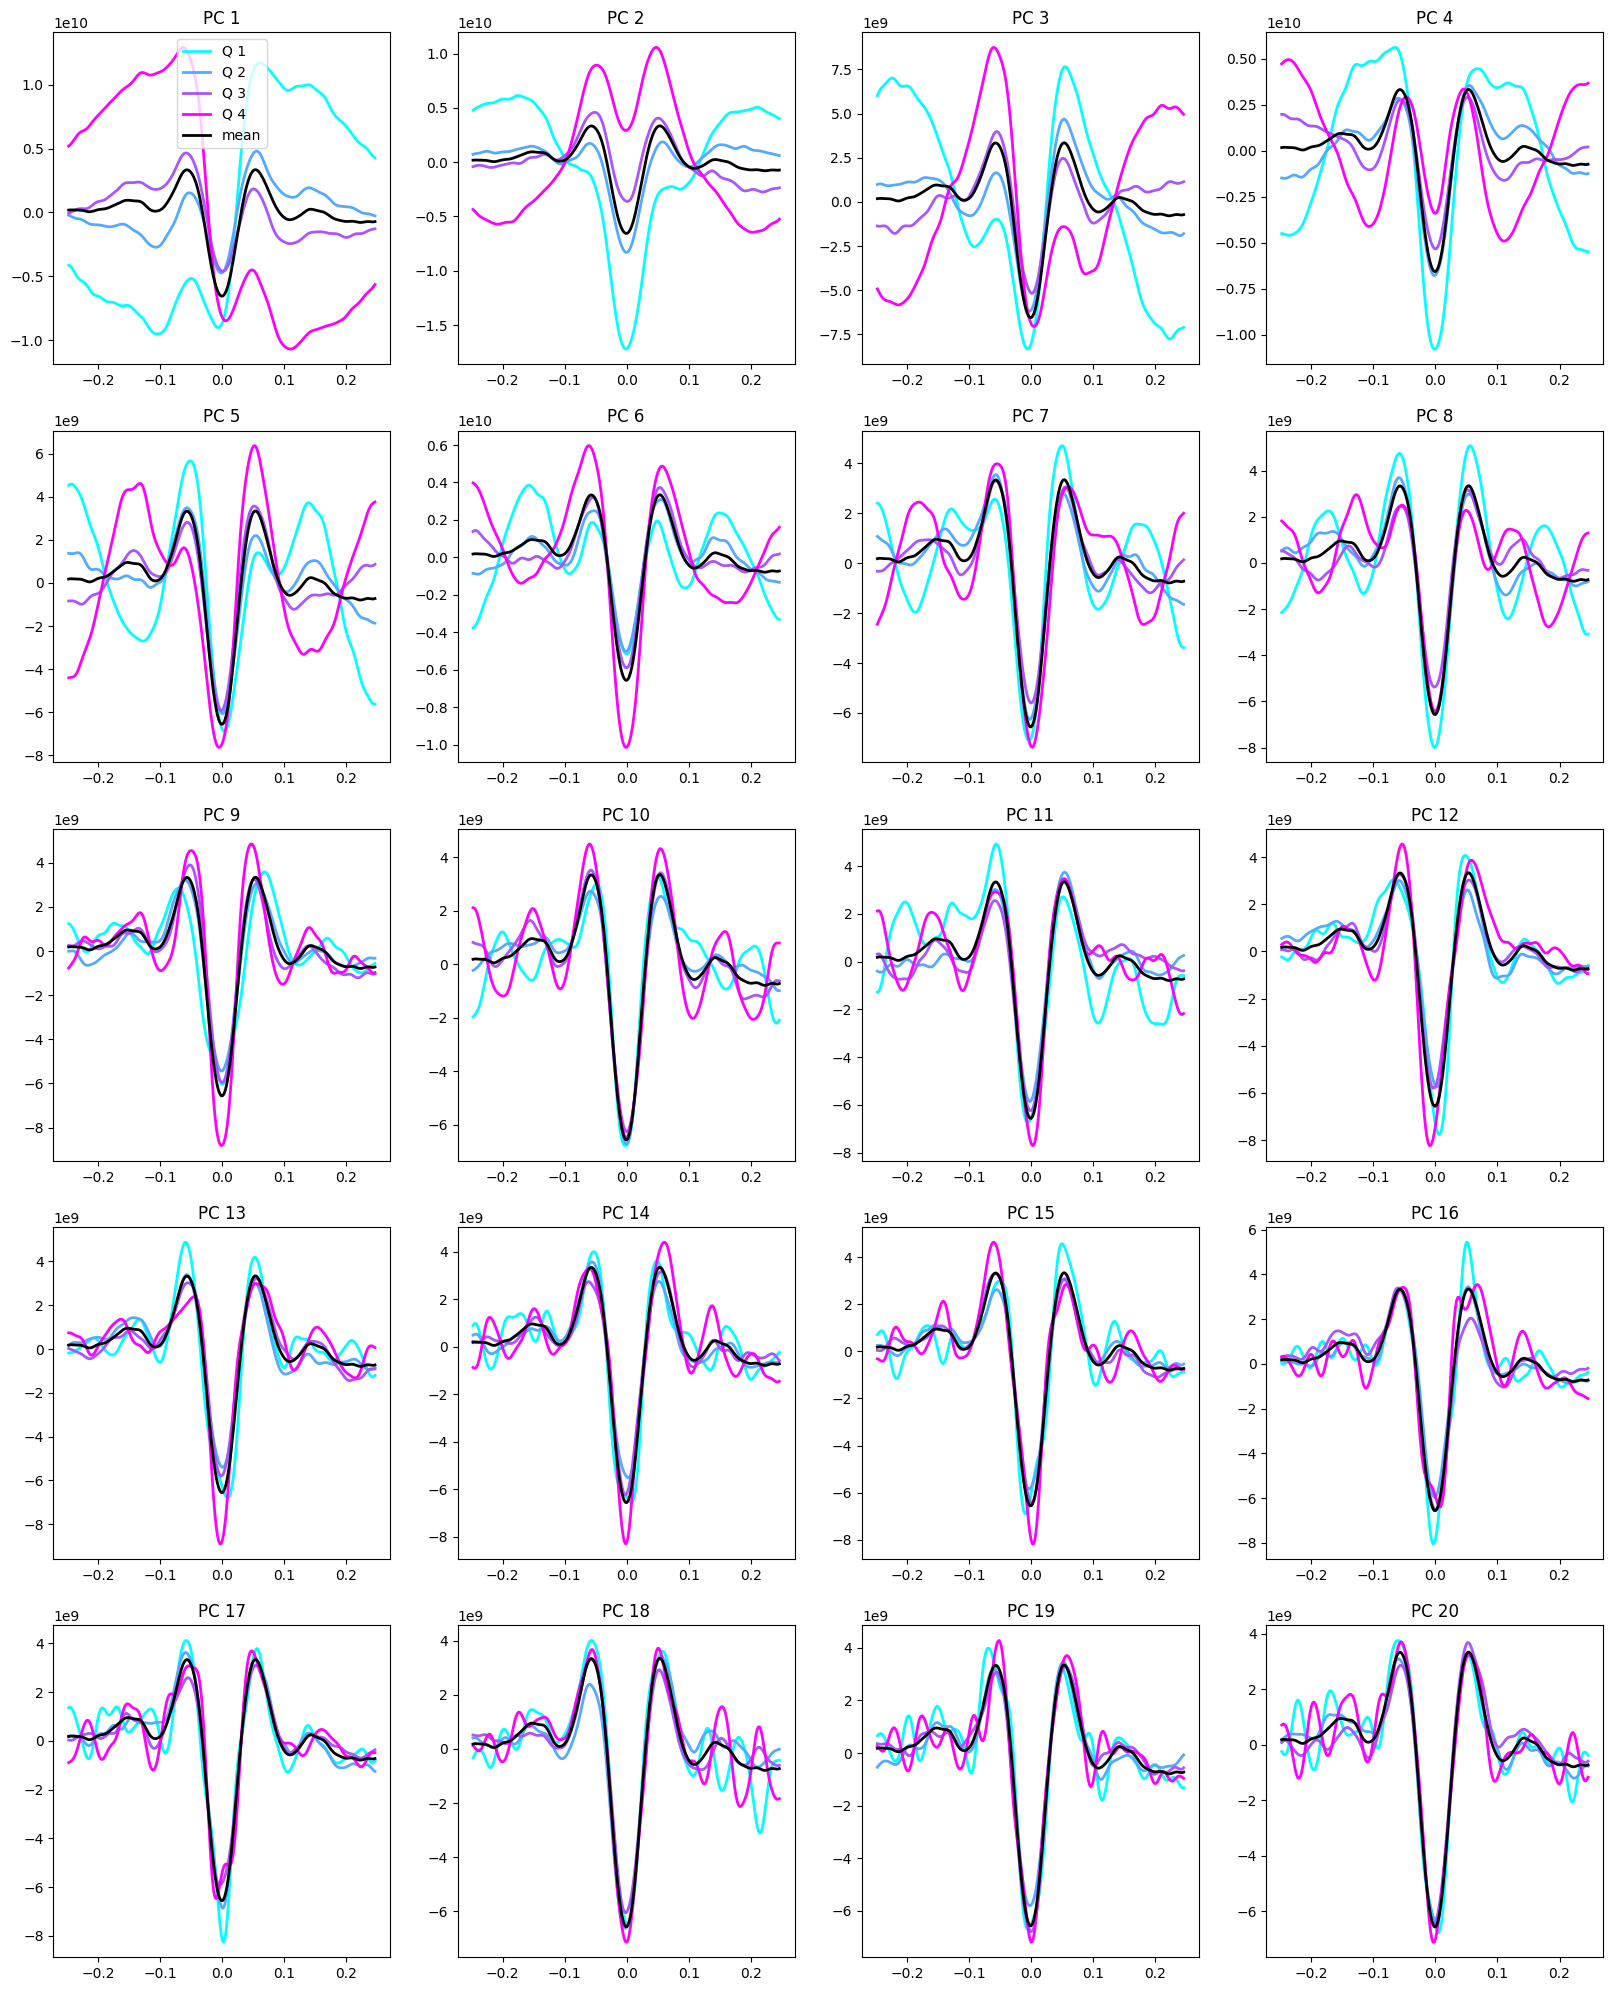

In [8]:
three_quartiles = np.linspace(0,100, num=5)
three_quartiles = list(zip(three_quartiles[:-1], three_quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0,1, num=len(three_quartiles)))
mean_waveform_three = np.mean(three_waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20,25))
ax = ax.flatten()
for pc_ix, pc in enumerate(three_pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " ")) # set the nice title
    scores = three_pc_scores[:,pc_ix]
    q_maps = []
    for q_ix, (b,e) in enumerate(three_quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e)) # create a boolean map to select the waveforms
        q_mean = np.mean(three_waveforms[q_map], axis=0)
        ax[pc_ix].plot(three_waveform_times, q_mean/1e-15, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(three_waveform_times, mean_waveform_three/1e-15, lw=2, c="black", label="mean")
    #ax[pc_ix].set_ylim(-200,200)
ax[0].legend(fontsize=10)
f.savefig('pc_plot_three_EGI.png', dpi=300)

In [9]:
file_path = 'bursts_six_EGI.json'
with open(file_path, 'r') as json_file:
    try:
        burst_six = json.load(json_file)
    except json.JSONDecodeError as e:
        raise ValueError(f"Error decoding JSON from file {file_path}: {e}")

In [10]:
flat_six_bursts={}
for key in burst_six[0]:
    if not key=='bursts':
        flat_six_bursts[key]=[]
    for sub_key in burst_six[0]['bursts']:
        flat_six_bursts[sub_key]=[]

for ch_bursts in burst_six:
    n_bursts=len(ch_bursts['bursts']['trial'])
    for key in ch_bursts:
        if not key=='bursts':
            for x in range(n_bursts):
                flat_six_bursts[key].append(ch_bursts[key]) 
        else:
            for sub_key in ch_bursts['bursts']:
                if not sub_key=='waveform_times':
                    flat_six_bursts[sub_key].extend(ch_bursts['bursts'][sub_key])
flat_six_bursts['waveform']=np.vstack(flat_six_bursts['waveform'])
flat_six_bursts['waveform_times']=burst_six[0]['bursts']['waveform_times']

In [11]:
six_model = PCA(n_components=20)
six_scaler = RobustScaler().fit(flat_six_bursts['waveform'])
six_waveform_std = six_scaler.transform(flat_six_bursts['waveform'])
six_model_model = six_model.fit(six_waveform_std)
six_pc_scores = six_model.transform(six_waveform_std) # all the bursts x 20 components 

In [12]:
six_waveforms = flat_six_bursts['waveform']
six_waveform_times=flat_six_bursts['waveform_times']

In [13]:
six_pc_labels = ["PC_{}".format(i+1) for i in range(six_pc_scores.shape[1])]
six_pc_df = pd.DataFrame.from_dict({i: six_pc_scores[:,ix] for ix, i in enumerate(six_pc_labels)})

In [14]:
six_pc_scores.shape

(23138, 20)

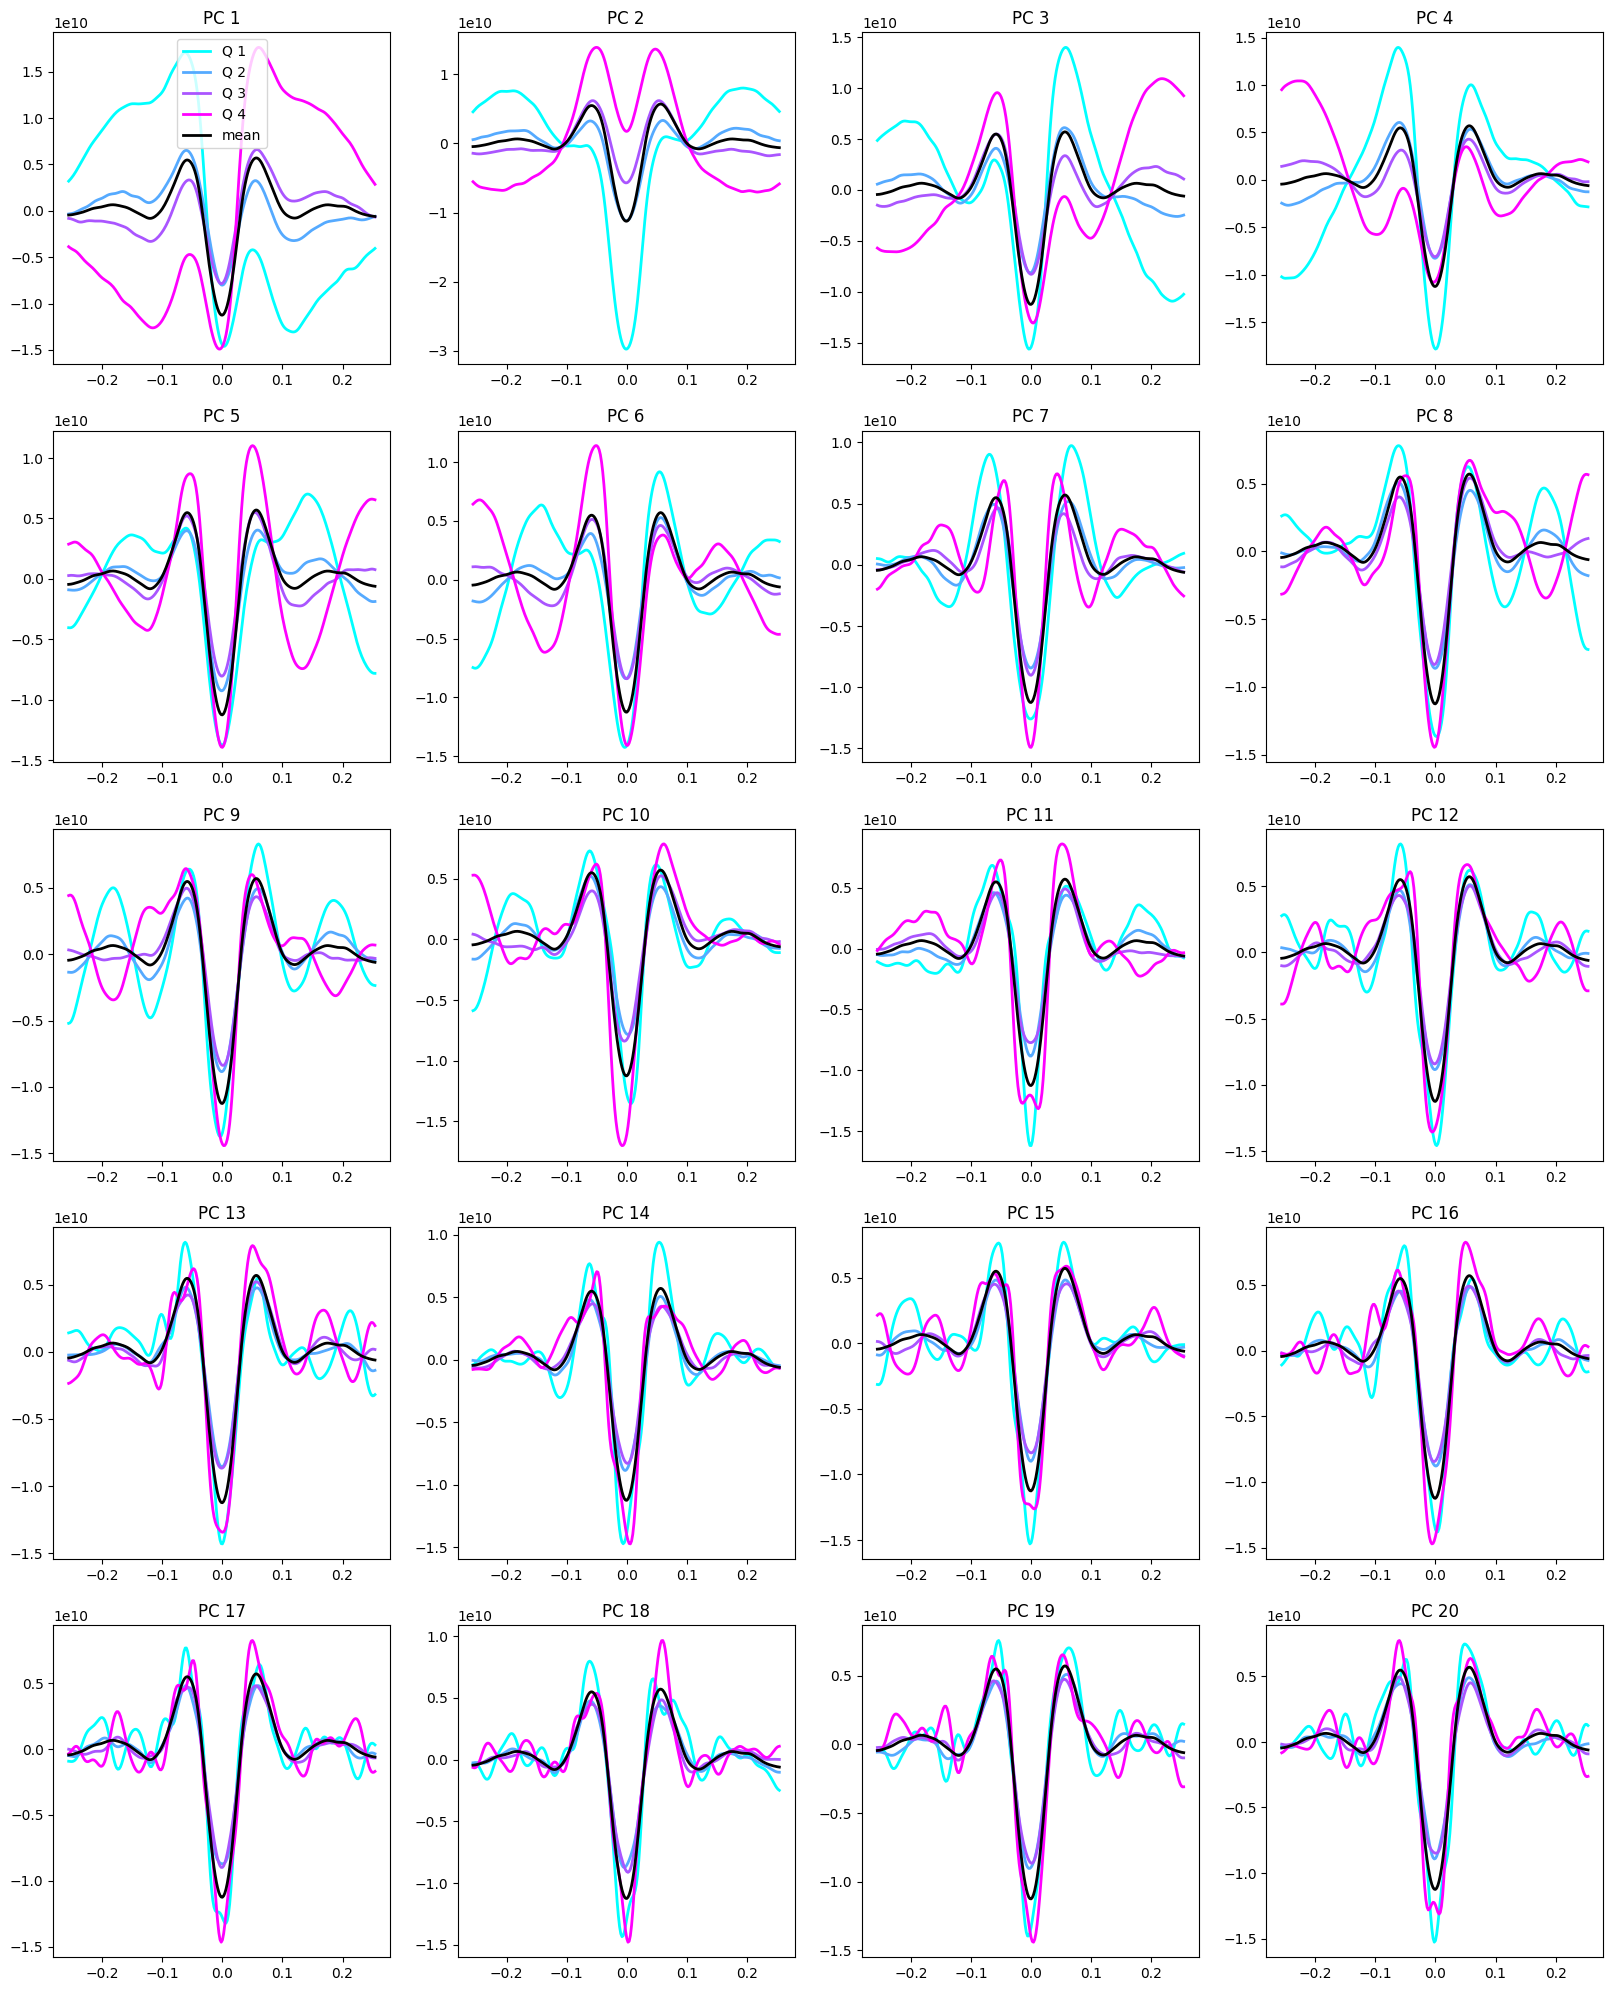

In [15]:
six_quartiles = np.linspace(0,100, num=5)
six_quartiles = list(zip(six_quartiles[:-1], six_quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0,1, num=len(six_quartiles)))
mean_waveform_six = np.mean(six_waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20,25))
ax = ax.flatten()
for pc_ix, pc in enumerate(six_pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " ")) # set the nice title
    scores = six_pc_scores[:,pc_ix]
    q_maps = []
    for q_ix, (b,e) in enumerate(six_quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e)) # create a boolean map to select the waveforms
        q_mean = np.mean(six_waveforms[q_map], axis=0)
        ax[pc_ix].plot(six_waveform_times, q_mean/1e-15, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(six_waveform_times, mean_waveform_six/1e-15, lw=2, c="black", label="mean")
    #ax[pc_ix].set_ylim(-200,200)
ax[0].legend(fontsize=10)
f.savefig('pc_plot_six_EGI.png', dpi=300)

In [16]:
file_path = 'bursts_twelve_EGI.json'
with open(file_path, 'r') as json_file:
    try:
        burst_twelve = json.load(json_file)
    except json.JSONDecodeError as e:
        raise ValueError(f"Error decoding JSON from file {file_path}: {e}")

In [17]:
flat_twelve_bursts={}
for key in burst_twelve[0]:
    if not key=='bursts':
        flat_twelve_bursts[key]=[]
    for sub_key in burst_twelve[0]['bursts']:
        flat_twelve_bursts[sub_key]=[]

for ch_bursts in burst_twelve:
    n_bursts=len(ch_bursts['bursts']['trial'])
    for key in ch_bursts:
        if not key=='bursts':
            for x in range(n_bursts):
                flat_twelve_bursts[key].append(ch_bursts[key]) 
        else:
            for sub_key in ch_bursts['bursts']:
                if not sub_key=='waveform_times':
                    flat_twelve_bursts[sub_key].extend(ch_bursts['bursts'][sub_key])
flat_twelve_bursts['waveform']=np.vstack(flat_twelve_bursts['waveform'])
flat_twelve_bursts['waveform_times']=burst_twelve[0]['bursts']['waveform_times']

In [18]:
twelve_model = PCA(n_components=20)
twelve_scaler = RobustScaler().fit(flat_twelve_bursts['waveform'])
twelve_waveform_std = twelve_scaler.transform(flat_twelve_bursts['waveform'])
twelve_model_model = twelve_model.fit(twelve_waveform_std)
twelve_pc_scores = twelve_model.transform(twelve_waveform_std) # all the bursts x 20 components 

In [19]:
twelve_waveforms = flat_twelve_bursts['waveform']
twelve_waveform_times=flat_twelve_bursts['waveform_times']

In [20]:
twelve_pc_labels = ["PC_{}".format(i+1) for i in range(twelve_pc_scores.shape[1])]
twelve_pc_df = pd.DataFrame.from_dict({i: twelve_pc_scores[:,ix] for ix, i in enumerate(twelve_pc_labels)})

In [21]:
twelve_pc_scores.shape

(5710, 20)

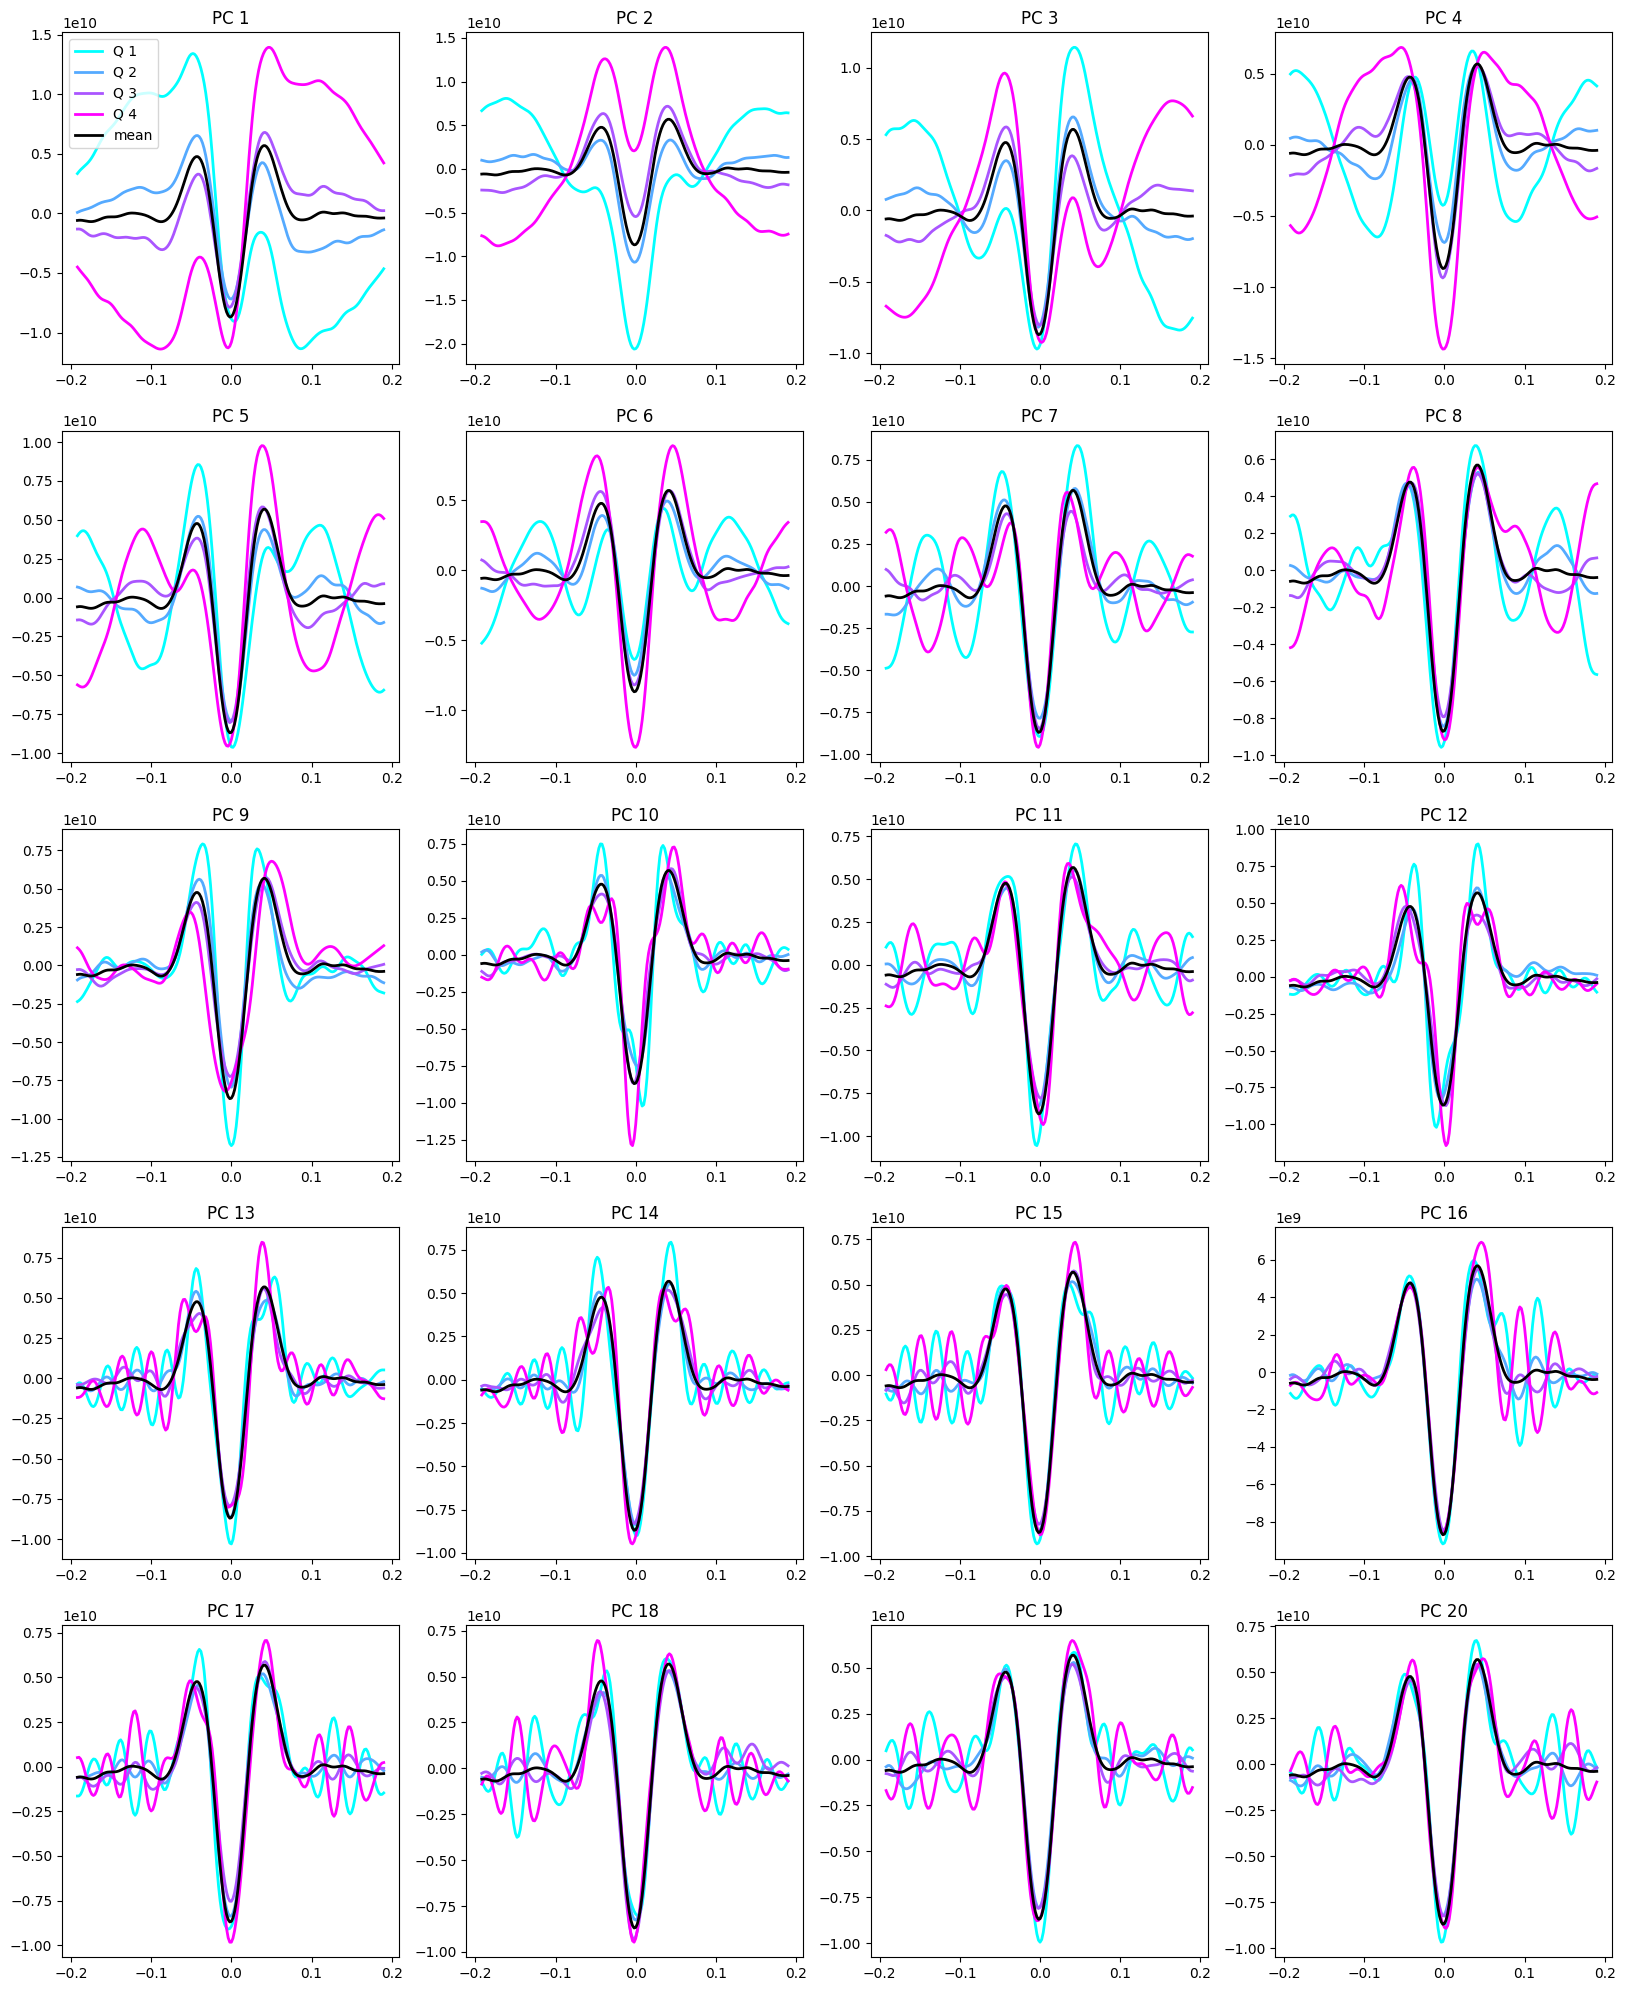

In [22]:
twelve_quartiles = np.linspace(0,100, num=5)
twelve_quartiles = list(zip(twelve_quartiles[:-1], twelve_quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0,1, num=len(twelve_quartiles)))
mean_waveform_twelve = np.mean(twelve_waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20,25))
ax = ax.flatten()
for pc_ix, pc in enumerate(twelve_pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " ")) # set the nice title
    scores = twelve_pc_scores[:,pc_ix]
    q_maps = []
    for q_ix, (b,e) in enumerate(twelve_quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e)) # create a boolean map to select the waveforms
        q_mean = np.mean(twelve_waveforms[q_map], axis=0)
        ax[pc_ix].plot(twelve_waveform_times, q_mean/1e-15, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(twelve_waveform_times, mean_waveform_twelve/1e-15, lw=2, c="black", label="mean")
    #ax[pc_ix].set_ylim(-200,200)
ax[0].legend(fontsize=10)
f.savefig('pc_plot_twelve_EGI.png', dpi=300)

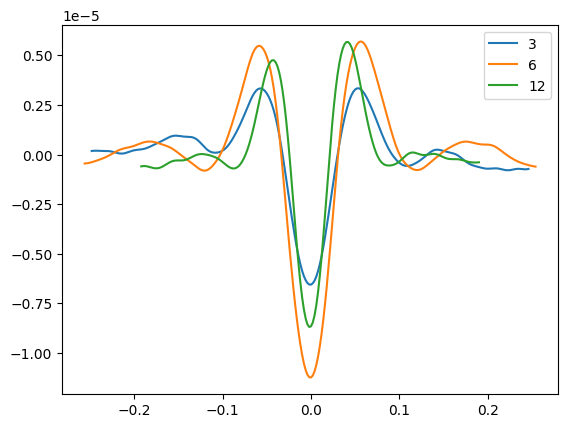

In [23]:
plt.plot(flat_three_bursts['waveform_times'], np.mean(flat_three_bursts['waveform'],axis=0), label='3')
plt.plot(flat_six_bursts['waveform_times'], np.mean(flat_six_bursts['waveform'],axis=0), label='6')
plt.plot(flat_twelve_bursts['waveform_times'], np.mean(flat_twelve_bursts['waveform'],axis=0), label='12')
plt.legend()

In [24]:
burst_times_3m=flat_three_bursts['waveform_times']
burst_times_12m=flat_twelve_bursts['waveform_times']
burst_times_six=flat_six_bursts['waveform_times']
med_3m=np.percentile(flat_three_bursts['waveform'], 50, axis=0)
med_12m=np.percentile(flat_twelve_bursts['waveform'], 50, axis=0)
med_6m=np.percentile(flat_six_bursts['waveform'], 50, axis=0)
norm_6m=med_6m/np.max(med_6m)
norm_12m=med_12m/np.max(med_12m)
norm_3m=med_3m/np.max(med_3m)
alignment_3m=dtw(norm_3m, norm_12m, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_3m_idx=warp(alignment_3m,index_reference=False)
alignment_6m=dtw(norm_6m, norm_12m, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_6m_idx=warp(alignment_6m,index_reference=False)
aligned_3m_bursts=flat_three_bursts['waveform'][:,aligned_3m_idx]
aligned_6m_bursts=flat_six_bursts['waveform'][:,aligned_6m_idx]
aligned_12m_bursts=flat_twelve_bursts['waveform']

aligned_c_bursts=np.vstack([aligned_3m_bursts,aligned_6m_bursts,aligned_12m_bursts])

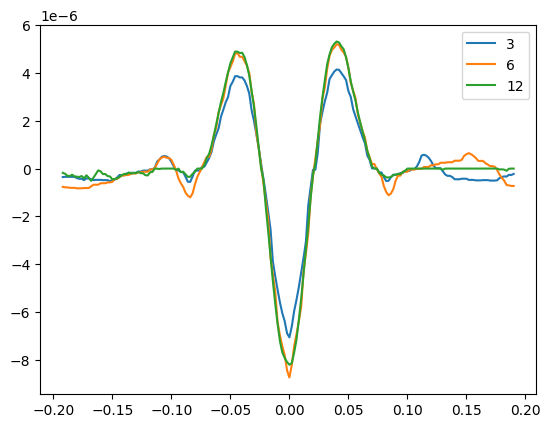

In [25]:
plt.plot(burst_times_12m, np.median(aligned_3m_bursts,axis=0),label="3")
plt.plot(burst_times_12m, np.median(aligned_6m_bursts,axis=0),label="6")
plt.plot(burst_times_12m, np.median(aligned_12m_bursts,axis=0),label="12")
plt.legend()

In [26]:
burst_std_3m = RobustScaler().fit_transform(aligned_3m_bursts)
burst_std_6m = RobustScaler().fit_transform(aligned_6m_bursts)
burst_std_12m = RobustScaler().fit_transform(aligned_12m_bursts)

In [27]:
pca_3m = PCA(n_components=20)
pca_3m=pca_3m.fit(burst_std_3m)
pcs_3m_3m = pca_3m.transform(burst_std_3m)

pca_6m = PCA(n_components=20)
pca_6m=pca_6m.fit(burst_std_6m)
pcs_6m_6m = pca_6m.transform(burst_std_6m)

pca_12m = PCA(n_components=20)
pca_12m=pca_12m.fit(burst_std_12m)
pcs_12m_12m = pca_12m.transform(burst_std_12m)


In [28]:
# Initialisation des matrices de corrélation
corrmat_3m_6m = np.zeros((pca_3m.n_components, pca_6m.n_components))  # Corrélation 3m vs 6m
corrmat_3m_12m = np.zeros((pca_3m.n_components, pca_12m.n_components))  # Corrélation 3m vs 12m
corrmat_6m_12m = np.zeros((pca_6m.n_components, pca_12m.n_components))  # Corrélation 6m vs 12m

for i in range(pca_3m.n_components):
    for j in range(pca_6m.n_components):
        # Corrélation entre les vecteurs de composantes principales (PC) de 3m et 6m
        res = spearmanr(pca_3m.components_[i, :], pca_6m.components_[j, :])
        corrmat_3m_6m[i, j] = np.abs(res[0])  # Valeur absolue de la corrélation
        
    for j in range(pca_12m.n_components):
        # Corrélation entre les vecteurs de composantes principales (PC) de 3m et 12m
        res = spearmanr(pca_3m.components_[i, :], pca_12m.components_[j, :])
        corrmat_3m_12m[i, j] = np.abs(res[0])  # Valeur absolue de la corrélation

for i in range(pca_6m.n_components):
    for j in range(pca_12m.n_components):
        # Corrélation entre les vecteurs de composantes principales (PC) de 6m et 12m
        res = spearmanr(pca_6m.components_[i, :], pca_12m.components_[j, :])
        corrmat_6m_12m[i, j] = np.abs(res[0])  # Valeur absolue de la corrélation


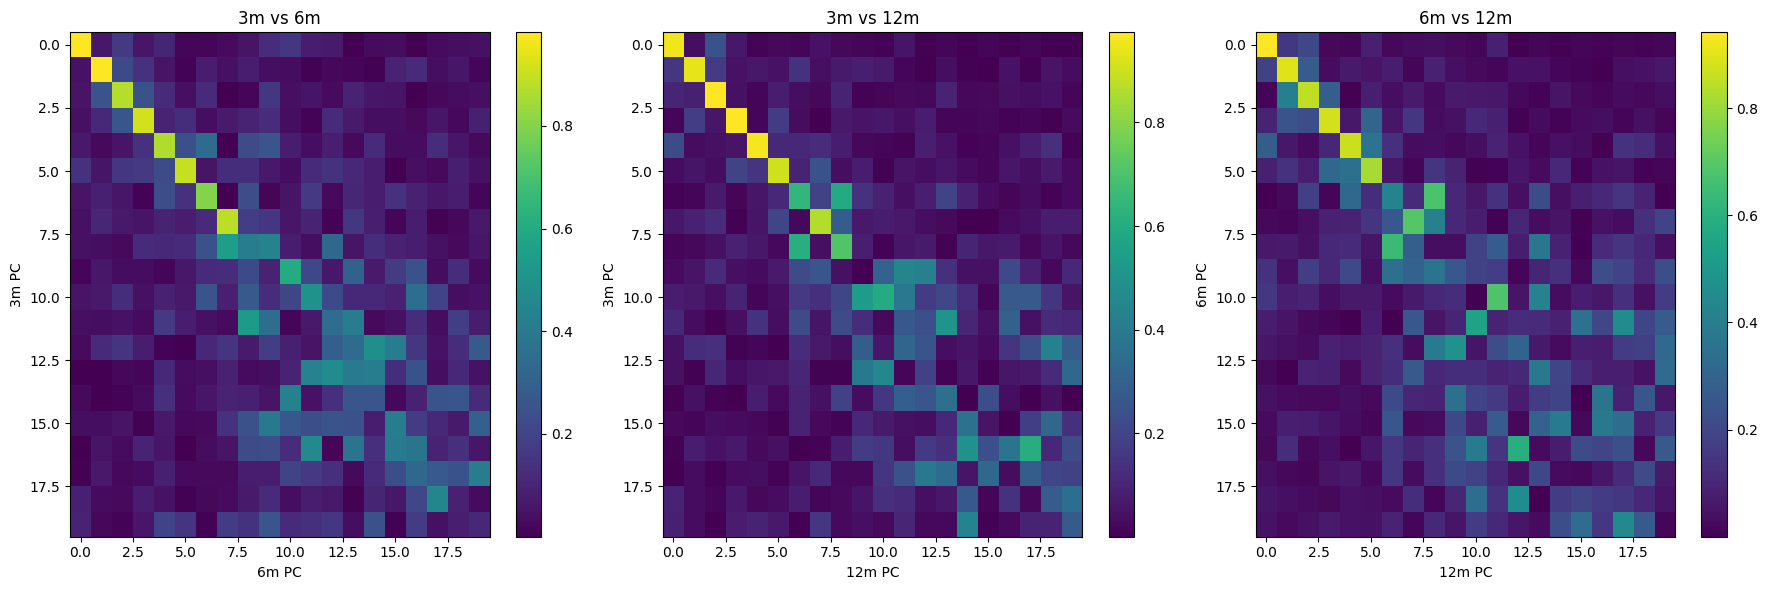

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 3m vs 6m
ax = axes[0]
cax = ax.imshow(corrmat_3m_6m, aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('3m vs 6m')
ax.set_xlabel('6m PC')
ax.set_ylabel('3m PC')

# 3m vs 12m
ax = axes[1]
cax = ax.imshow(corrmat_3m_12m, aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('3m vs 12m')
ax.set_xlabel('12m PC')
ax.set_ylabel('3m PC')

# 6m vs 12m
ax = axes[2]
cax = ax.imshow(corrmat_6m_12m, aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('6m vs 12m')
ax.set_xlabel('12m PC')
ax.set_ylabel('6m PC')

plt.tight_layout()
plt.show()

In [30]:
c_pca = PCA(n_components=20)

burst_std_c=np.vstack([burst_std_3m, burst_std_6m, burst_std_12m])
c_pca=c_pca.fit(burst_std_c)

pcs_3m = c_pca.transform(burst_std_3m)
pcs_6m = c_pca.transform(burst_std_6m)
pcs_12m = c_pca.transform(burst_std_12m)

pca_components_3mm = pd.DataFrame(pcs_3m)
pca_components_6m = pd.DataFrame(pcs_6m)
pca_components_12m = pd.DataFrame(pcs_12m)

pcs_c=np.vstack([pcs_3m,pcs_6m,pcs_12m])

In [31]:
cum_var_exp=np.cumsum(c_pca.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx_c=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx_c=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx_c+1,cum_var_exp[idx_c]*100))

5 components explain 82.11008336589359% of variance


In [32]:
cum_var_exp=np.cumsum(pca_3m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx_3m=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx_3m=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx_3m+1,cum_var_exp[idx_3m]*100))

4 components explain 82.09760190584015% of variance


In [33]:
cum_var_exp=np.cumsum(pca_6m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx_6m=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx_6m=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx_6m+1,cum_var_exp[idx_6m]*100))

5 components explain 81.02945304492187% of variance


In [34]:
cum_var_exp=np.cumsum(pca_12m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx_12m=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx_12m=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx_12m+1,cum_var_exp[idx_12m]*100))

6 components explain 83.30611074354857% of variance


In [35]:
# Initialisation des matrices de corrélation
corrmat_3m_c = np.zeros((pca_3m.n_components, c_pca.n_components))  
corrmat_6m_c = np.zeros((pca_6m.n_components, c_pca.n_components))  
corrmat_12m_c = np.zeros((pca_12m.n_components, c_pca.n_components))  

# Corrélation entre les PC locales et les PC globales
for i in range(pca_3m.n_components):
    for j in range(c_pca.n_components):
        res = spearmanr(pca_3m.components_[i, :], c_pca.components_[j, :])  
        corrmat_3m_c[i, j] = np.abs(res[0])  # Corrélation absolue entre 3m et PCA globale

for i in range(pca_6m.n_components):
    for j in range(c_pca.n_components):
        res = spearmanr(pca_6m.components_[i, :], c_pca.components_[j, :])  
        corrmat_6m_c[i, j] = np.abs(res[0])  # Corrélation absolue entre 6m et PCA globale

for i in range(pca_12m.n_components):
    for j in range(c_pca.n_components):
        res = spearmanr(pca_12m.components_[i, :], c_pca.components_[j, :])  
        corrmat_12m_c[i, j] = np.abs(res[0])  # Corrélation absolue entre 12m et PCA globale



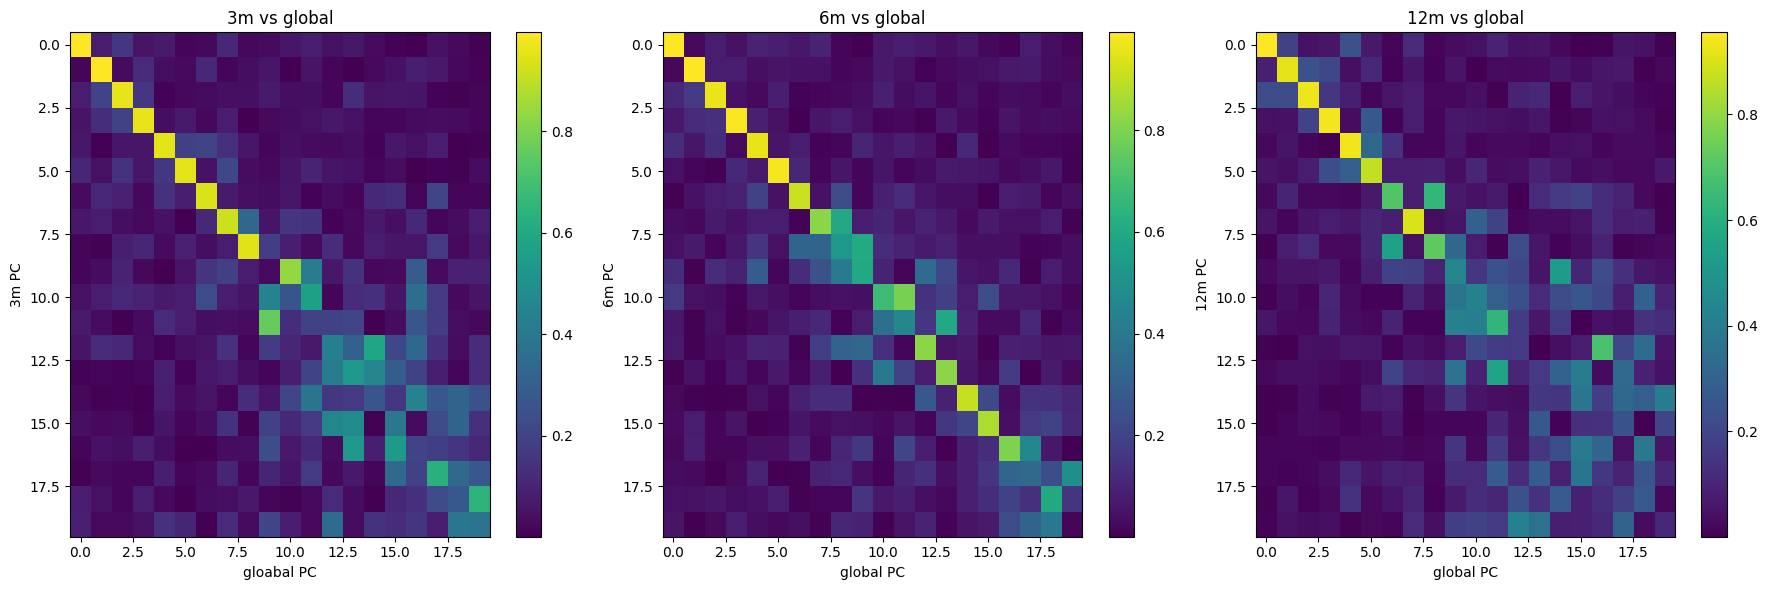

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 3m vs 6m
ax = axes[0]
cax = ax.imshow(corrmat_3m_c, aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('3m vs global')
ax.set_xlabel('gloabal PC')
ax.set_ylabel('3m PC')

# 3m vs 12m
ax = axes[1]
cax = ax.imshow(corrmat_6m_c, aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('6m vs global')
ax.set_xlabel('global PC')
ax.set_ylabel('6m PC')

# 6m vs 12m
ax = axes[2]
cax = ax.imshow(corrmat_12m_c, aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('12m vs global')
ax.set_xlabel('global PC')
ax.set_ylabel('12m PC')

plt.tight_layout()
plt.show()

In [37]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array


def get_num_components(waveforms, n_comps):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=n_comps)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=n_comps)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    threshold=1-(.05/n_comps)
    PCS_to_analyse = len(np.where(results > threshold)[0])
    return PCS_to_analyse

In [38]:
pcs_to_analyze_3m=get_num_components(three_waveforms, idx_3m+1)
print('C: {}'.format(pcs_to_analyze_3m))

C: 4


In [39]:
pcs_to_analyze_6m=get_num_components(six_waveforms, idx_6m+1)
print('C:{}'. format(pcs_to_analyze_6m))

C:5


In [40]:
pcs_to_analyze_12m=get_num_components(twelve_waveforms, idx_12m+1)
print('C:{}'. format(pcs_to_analyze_12m))

C:6


In [41]:
pcs_to_analyze_c=get_num_components(aligned_c_bursts,idx_c)
print('C:{}'.format(pcs_to_analyze_c))

C:4
